In [2]:
import time

import matplotlib.pyplot as plt
from pymongo import MongoClient
import pandas as pd
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Hypothesis H1 analysis
#### This notebook is dedicated to the exploration of the Hypotesis H1
This hypothesis has an explorative nature. The main goal is to find out if there exists topics discussed in the reviews by aribnb users that are valued higly by users.
To do so we first build a LDA model that is able to extract topics discussed in reviews in an unsupervised way. This was done in a previous script.
Reviews are splitted in phrases and for each phrase the greatest topic probability is chosen as a topic score and with sentiment analyisis we give a sentiment score to each phrase. More detail later. The various phrases in a review are combined in a review topic-sentiment matrix. We have tried to predict in which price category an airbnb falls in to using this matrixes to build a predictor.

## Producing the review_topic_sentiment matirx
#### As a first thing i copy the methods used to clean and tokenize the reviews. This is done to simulate the ingestion of new reviews.

In [230]:
# preprocessing function

def preprocess(text):
    with open(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\host_names.pkl', 'rb') as name_file:
        host_names = pickle.load(name_file)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = ['host' if word in host_names else word for word in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

def get_topic(topic_distribution):
    return topic_distribution.argmax()


# loading the chosen LDA model
lda = r'C:\Users\flavi\PycharmProjects\lda_test\ldaS\lda_8_Mdf90_mdf10_100EPOCHS.pkl'
print('Loading lda...')
with open(lda, 'rb') as lda_file:
    LDA = pickle.load(lda_file)

# creating the vectorizer 
vectorizer_file = r'C:\Users\flavi\PycharmProjects\lda_test\ldaS\vectorizer_8_Mdf_90_10_100EPOCHS.pkl'
print('Loading vectorizer...')
vectorizer = pickle.load(open(vectorizer_file, 'rb'))
 
#vectorizer = CountVectorizer(max_df=0.90, min_df=10, stop_words='english')

# loading the vader sentiment analizer

sia = SentimentIntensityAnalyzer()

Loading lda...
Loading vectorizer...


#### Here are the strategies used to translate each review in to a matrix
1) This first strategy computes as a topic score the probability that a review talks about a given topic. then the review gets splitted in to phrases and once each phrase gets its chosen topic, a sentiment score is applied to it. Now we average the sentiment score per phrase topic and the result of this gets saved as the second column

In [231]:
sample_rev = """Our stay with Daniel was truly one of the highlights of mine and my partner's whirlwind European tour. Not only was the room smashingly decorated (a great example of modern Dutch living), spotlessly clean and serenely comfortable {think Zen), but having Daniel as a point of reference was our key to discovering the city. From the get-go he freely offered advice whenever we had questions about where to go or what to do in Amsterdam. 

The room is located at quite a distance from the heart of the city, but we didn't find this hindering. We were able to get to the center in a snap with the two bikes Daniel has available for a minimal charge or via any of the train or bus stops located within a stones throw of his front door. There are plenty of restaurants, cafes and groceries in the area. And staying here is also a great way to see how the locals are living.

I would recommend Daniel's residence to anyone looking for a smart, affordable alternative to hotels or hostels. As a gay couple especially we found him extremely welcoming. 

P.S. You can check my YouTube page for videos of our stay in Amsterdam, which includes a peek into the room: (Website hidden by Airbnb)"""


def get_topic(topic_distribution):
    return topic_distribution.argmax()

def review_to_matrix_1(text, LDA, vectorizer, sia):
    
    processed_text = [preprocess(text)]
    vect_rev = vectorizer.transform(processed_text)
    rev_topic_scores = LDA.transform(vect_rev)
    n_of_topics = len(rev_topic_scores[0])
    document_matrix = np.zeros((2, n_of_topics))
    sentences = nltk.sent_tokenize(text=text, language='english')
    max_topic_scores = np.zeros(n_of_topics)
    topic_frequency = np.ones(n_of_topics)
    topic_sentiment_accumulator = np.zeros(n_of_topics)
    for sentence in sentences:
        processed_sentence = [preprocess(sentence)]
        sentence_topic_scores = LDA.transform(vectorizer.transform(processed_sentence))
        topic = get_topic(sentence_topic_scores)
        topic_frequency[topic] += 1
        #('Current sentence:',sentence)
        #print('Topic sentence:', topic)
       # print(sentence_topic_scores[0][topic])
        if sentence_topic_scores[0][topic] > max_topic_scores[topic]:
            max_topic_scores[topic] = sentence_topic_scores[0][topic]
        sentiment = sia.polarity_scores(sentence).get('compound')
        topic_sentiment_accumulator[topic] += sentiment
        #print('Compound sentiment:', sentiment)
    document_matrix[0,:] = max_topic_scores
    document_matrix[1,:] = topic_sentiment_accumulator/topic_frequency

    return document_matrix
    

    
test_rev1_df = pd.DataFrame(review_to_matrix_1(LDA=LDA, vectorizer=vectorizer,text= sample_rev, sia=sia))
print(test_rev1_df)

          0         1         2         3         4         5    6         7
0  0.510827  0.496015  0.902692  0.578112  0.363342  0.854145  0.0  0.644207
1 -0.051033  0.000000  0.293600  0.164233  0.433533  0.000000  0.0  0.318450


We migth need to tune vader for our specific use case. If the classifier for the prices 

## Classifying the reviews
The next step is to classify the reviews for all the documents and for each lising to compute the average review matrix

In [3]:
# Connettersi al client MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['dsbda_project']
collection = db['row']

# RESTRIZIONE APPLICATA AI DATI, per gestire volume
data_inizio = "2009-01-01"
data_fine = "2018-12-31"

# Query per selezionare i campi specificati
query = {
    "date": {
        "$gte": data_inizio,
        "$lte": data_fine
    }
}

# Seleziona i campi desiderati
projection = {
    "_id": 0,  # Escludi il campo _id
    "listing_id": 1,
    "price" : 1,
    "name" : 1,
    "host_name" : 1,
    "host_id" : 1,
    "longitude": 1,
    "latitude": 1,
    "date": 1,
    "comment": 1
}

cursor = collection.find(query, projection)
data = list(cursor)
df_reviews_full = pd.DataFrame(data)

print(df_reviews_full.head())


   listing_id                              name  host_name   latitude  \
0     9996278  Stylish family house near centre       Imke  52.391568   
1     9996278  Stylish family house near centre       Imke  52.391568   
2     9996278  Stylish family house near centre       Imke  52.391568   
3     9996278  Stylish family house near centre       Imke  52.391568   
4     9992899    Cozy Canal House in the centre  Liselotte  52.375860   

   longitude  price        date  \
0   4.926035   65.0  2016-02-22   
1   4.926035   65.0  2016-02-07   
2   4.926035   65.0  2016-01-24   
3   4.926035   65.0  2015-12-31   
4   4.893092   79.0  2016-02-21   

                                             comment  
0  My friends and I really enjoyed our stay at Im...  
1  I enjoyed Imkes place Despite the fact that th...  
2  Probably the coolest house in Amsterdam. All o...  
3              Vert nice house We spend a great stay  
4  We loved every minute of our stay here. Liselo...  


In [6]:
import csv
# The first thing is to load the dataframe and check if it is correctly loaded.
#csv_file_path= r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset.csv'
#df_reviews_full = pd.read_csv(csv_file_path, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
df_reviews_full = df_reviews_full.dropna()
df_reviews_full = df_reviews_full.sort_values(by='listing_id')
df_reviews_full = df_reviews_full.sample(frac=1).reset_index(drop = True)
print(df_reviews_full.head(50))

    listing_id                                               name  \
0     22643412  Classic houseboat in the city center of Amsterdam   
1      1056269        Your home in Amsterdam is spacious and cosy   
2      1468473                       Light and bright appartement   
3       683431                            Cozy Room Rivierenbuurt   
4     21670358               Unique large design family apartment   
5       834233              BB Mondriaan bright and modern studio   
6     15118725                   Apartment in city centre JORDAAN   
7      7450864                Nice apartment close to City Centre   
8      8434745                Lovely houseboat in the old centre.   
9     20203512                                          BSZ HOUSE   
10    20158135                         Cosy studio great location   
11    14568123                        Cheap room Amsterdam center   
12     9323377                      Cozy Studios in Heart of Pijp   
13      137026                Enti

In [329]:
# imports to have a progress bar displayed
from tqdm import tqdm
from tqdm.auto import tqdm

In [330]:
# The dataset is sorted on id now we add a column with the review matrix 
# Now we translate each review in a review matrix
print(len(df_reviews_full))
print('Processing reviews...')

tqdm.pandas()

df_reviews_full['rev_matrix'] = df_reviews_full['comments'].progress_apply(review_to_matrix_1,args=(LDA, vectorizer, sia))
print(df_reviews_full['rev_matrix'])

340142
Processing reviews...


  0%|          | 0/340142 [00:00<?, ?it/s]

0         [[0.0, 0.0, 0.0, 0.0, 0.824761717888543, 0.0, ...
1         [[0.0, 0.8248099216733732, 0.6900836368994313,...
2         [[0.0, 0.0, 0.720797534597365, 0.4377783178327...
3         [[0.0, 0.0, 0.0, 0.0, 0.8248885987743209, 0.92...
4         [[0.9203379169222462, 0.0, 0.0, 0.537769587419...
                                ...                        
340137    [[0.0, 0.0, 0.0, 0.0, 0.8540444729774042, 0.56...
340138    [[0.0, 0.0, 0.0, 0.0, 0.8248700250853411, 0.61...
340139    [[0.0, 0.7810938519101118, 0.0, 0.0, 0.0, 0.0,...
340140    [[0.7081212690757103, 0.9027136639122901, 0.45...
340141    [[0.0, 0.0, 0.0, 0.0, 0.7081440664199876, 0.0,...
Name: rev_matrix, Length: 340142, dtype: object


In [1]:
#save the output csv
df_reviews_full.to_csv(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset_with_rev_matrix.csv')

NameError: name 'df_reviews_full' is not defined

In [331]:
# Now we compute the average for each airbnb and save the result in a new dataframe
tqdm.pandas()
def calculate_avg_rev_matrix(x):
    return np.mean(np.array(x.tolist()), axis=0)

df_avg_reviews = df_reviews_full.groupby('id')['rev_matrix'].progress_apply(calculate_avg_rev_matrix)
#print(df_avg_reviews.head(20))

df_avg_reviews = df_reviews_full.merge(df_avg_reviews, on='id',suffixes=('','_avg'))

#print(df_avg_reviews.head(20))

df_avg_reviews['price'] = df_avg_reviews['price'].str.replace(r"[\$,]", "", regex = True).astype(float)

print(df_avg_reviews.head(10))

df_avg_reviews.to_csv(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset_with_avg_rev_matrix.csv')

  0%|          | 0/17040 [00:00<?, ?it/s]

   Unnamed: 0        id                                             name  \
0      119637   4349963                        Family house in Amsterdam   
1      117835   4240895  Beautiful sunny apartment on a perfect location   
2      217536  12451293     Hotel in the heart of Amsterdam, Single room   
3      332990  26105238     Amsterdam Apartment With Nice Indoor Balcony   
4      299322  19818979        lovely apartment close to Central Station   
5      277905  17824002               Modern, luxury apt with canal view   
6      149816   6332902                  Enjoy 17th Century Canal House!   
7      227742  13262950       Spacious apartment with sunny roof terrace   
8       44309    881384   Artists Studio in vivid Zeeburg (limited wifi)   
9      268047  16700980      Great central apt for people who enjoy life   

    latitude  longitude  price        host_name    host_id  listing_id  \
0  52.391936   4.934096  129.0           Gerard    4100544     4349963   
1  52.380612   

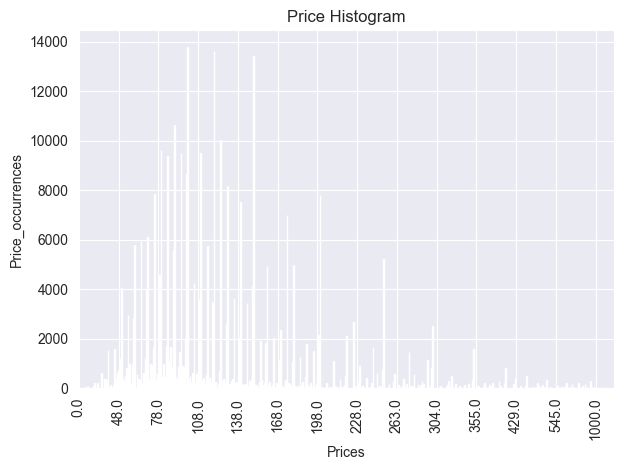

8


In [332]:
# Now we want to decide how to bin the prices in order to decide how to best bin them
import matplotlib.ticker as ticker

price_counts = df_avg_reviews['price'].value_counts()
price_counts = price_counts.sort_index()
price_counts.plot(kind='bar')
plt.title('Price Histogram')
plt.xlabel('Prices')
plt.ylabel('Price_occurrences')
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=15)) 
plt.show()
print(price_counts.iloc[0])

In [239]:
prices = df_avg_reviews['price'].unique()
prices.sort()
print(prices)

[   0.    8.   12.   23.   24.   25.   26.   28.   29.   30.   32.   33.
   35.   36.   37.   38.   39.   40.   41.   42.   44.   45.   46.   47.
   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.
   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.
   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.
   96.   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.
  108.  109.  110.  111.  112.  113.  114.  115.  116.  117.  118.  119.
  120.  121.  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.
  132.  133.  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.
  144.  145.  146.  147.  148.  149.  150.  151.  152.  153.  154.  155.
  156.  157.  158.  159.  160.  161.  162.  163.  164.  165.  166.  167.
  168.  169.  170.  171.  172.  173.  174.  175.  176.  177.  178.  179.
  180.  181.  182.  183.  184.  185.  186.  187.  1

From this plot we are able to extract the bins. We have decided to hand-pick the bins in order to put a more 'human' touch on the price range choice.
We also have discarded some absurdly high and absurdly low prices. This is done to remove the ifluence from misleading listings and listing-squatting

In [333]:
# now we create a function that returns the bin tag given the price

bin_tags_1 = ['EXTRA_CHEAP','CHEAP','AFFORDABLE','AVERAGE_PRICE','MID_HIGH','EXPENSIVE','EXTRA_EXPENSIVE','LUXURY']
bin_intervals_1 = [(0,35),(35,55),(55,100),(100,150),(150,200),(200,300),(300,450),(450,3000)]

bin_tags_2 = ['CHEAP','AFFORDABLE','MID','EXPENSIVE','LUXURY']

bin_intervals_2 = [(0,75),(75,200),(200,300),(300,450),(450,3000)]
bin_intervals_3 = [(0,50),(50,70),(70,80),(80,90),(90,95),(95,100),(100,110),(120,130),(130,140),(150,160),(160,170),(170,180),(180,190),(200,300),(300,450),(450,3000)]

def price_to_bin_ID(price):
    for i, (start, end) in enumerate(bin_intervals_2):
        if start <= price < end:
            return i
    return -1

print(bin_tags_2[price_to_bin_ID(90)])

AFFORDABLE


In [334]:
# with the price bins defined now we proceed to start cutting the dataframe to prepare it for training

useful_columns_1 = ['id','rev_matrix','price']
df_cut = df_avg_reviews[useful_columns_1]
#print(df_cut.head(10))
print(df_cut.shape[0])
df_cut['price_bin'] = df_cut['price'].apply(price_to_bin_ID)
useful_columns_2 = ['id','rev_matrix','price_bin']
df_cut = df_cut[useful_columns_2]
df_cut = df_cut.loc[df_cut['price_bin']!=-1]

print(df_cut.head(10))
print(df_cut.shape[0])

340142
         id                                         rev_matrix  price_bin
0   4349963  [[0.0, 0.0, 0.0, 0.0, 0.824761717888543, 0.0, ...          1
1   4240895  [[0.0, 0.8248099216733732, 0.6900836368994313,...          1
2  12451293  [[0.0, 0.0, 0.720797534597365, 0.4377783178327...          1
3  26105238  [[0.0, 0.0, 0.0, 0.0, 0.8248885987743209, 0.92...          1
4  19818979  [[0.9203379169222462, 0.0, 0.0, 0.537769587419...          1
5  17824002  [[0.0, 0.0, 0.0, 0.4190118981353617, 0.8749034...          2
6   6332902  [[0.7082135407697511, 0.0, 0.0, 0.0, 0.0, 0.0,...          1
7  13262950  [[0.0, 0.0, 0.0, 0.0, 0.8249297945930262, 0.0,...          1
8    881384  [[0.5569125411320491, 0.8748746384004354, 0.57...          1
9  16700980  [[0.0, 0.8248365603632791, 0.0, 0.854018480477...          0
340115


C:\Users\flavi\AppData\Local\Temp\ipykernel_24268\799393400.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['price_bin'] = df_cut['price'].apply(price_to_bin_ID)


The next operation is to explode the matrix in the rev_matrix field. The matrix gets flattened by multiplying each value of the first row by the corresponding one in the second row. This is just one strategy to take in to account the weigh of the topic in each review. I could also just use the topic probabilities or the overall sentiment of each topic alone.

In [335]:
def multiply_rev_matrix(rev_matrix):
    return np.multiply(rev_matrix[0],rev_matrix[1])

print('Multiplication test:', multiply_rev_matrix(np.array([[1,2,3,4],[1,2,3,4]])))

Multiplication test: [ 1  4  9 16]


In [336]:
def multiply_and_normalize(rev_matrix):
    return np.multiply(rev_matrix[0],(rev_matrix[1]+1))

In [337]:
def just_topic_scores(rev_matrix):
    return rev_matrix[0]

In [338]:
def just_sentiment(rev_matrix):
    return rev_matrix[1]

In [339]:
#print(df_cut.head(10))
print(df_cut['rev_matrix'].head(10))
#df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(multiply_rev_matrix)
#df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(just_sentiment)
#df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(just_topic_scores)
df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(multiply_and_normalize)
print(df_cut.head(10))

scores_df = pd.DataFrame(df_cut['rev_matrix'].tolist(),index=df_cut.index)
print(scores_df.head(10))

scores_df.columns = ['Ts_0','Ts_1','Ts_2','Ts_3','Ts_4','Ts_5','Ts_6','Ts_7']
df_cut = pd.concat([df_cut.drop(columns = ['rev_matrix']),scores_df], axis=1)
df_cut.to_csv(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset_for_training.csv')
zeros = (df_cut == 0.0).all(axis=1)
df_cut = df_cut[~zeros]
zeros = df_cut.eq(0.0).any(axis = 1)
#df_cut = df_cut[~zeros]
print(df_cut.head(10))

0    [[0.0, 0.0, 0.0, 0.0, 0.824761717888543, 0.0, ...
1    [[0.0, 0.8248099216733732, 0.6900836368994313,...
2    [[0.0, 0.0, 0.720797534597365, 0.4377783178327...
3    [[0.0, 0.0, 0.0, 0.0, 0.8248885987743209, 0.92...
4    [[0.9203379169222462, 0.0, 0.0, 0.537769587419...
5    [[0.0, 0.0, 0.0, 0.4190118981353617, 0.8749034...
6    [[0.7082135407697511, 0.0, 0.0, 0.0, 0.0, 0.0,...
7    [[0.0, 0.0, 0.0, 0.0, 0.8249297945930262, 0.0,...
8    [[0.5569125411320491, 0.8748746384004354, 0.57...
9    [[0.0, 0.8248365603632791, 0.0, 0.854018480477...
Name: rev_matrix, dtype: object
         id                                         rev_matrix  price_bin
0   4349963  [0.0, 0.0, 0.0, 0.0, 1.1654295454624057, 0.0, ...          1
1   4240895  [0.0, 0.9602712044761967, 0.8349666964664669, ...          1
2  12451293  [0.0, 0.0, 0.720797534597365, 0.60597274754405...          1
3  26105238  [0.0, 0.0, 0.0, 0.0, 0.9906499626980206, 1.293...          1
4  19818979  [0.9203379169222462, 0.0, 0.0, 0.69

In [340]:
print(df_cut.head(10))
print(df_cut.shape[0])

         id  price_bin      Ts_0      Ts_1      Ts_2      Ts_3      Ts_4  \
0   4349963          1  0.000000  0.000000  0.000000  0.000000  1.165430   
1   4240895          1  0.000000  0.960271  0.834967  0.578748  0.602304   
2  12451293          1  0.000000  0.000000  0.720798  0.605973  1.152521   
3  26105238          1  0.000000  0.000000  0.000000  0.000000  0.990650   
4  19818979          1  0.920338  0.000000  0.000000  0.691545  1.227562   
5  17824002          2  0.000000  0.000000  0.000000  0.419012  1.209624   
6   6332902          1  0.708214  0.000000  0.000000  0.000000  0.000000   
7  13262950          1  0.000000  0.000000  0.000000  0.000000  1.174741   
8    881384          1  0.556913  1.235177  0.842394  0.000000  1.087536   
9  16700980          0  0.000000  0.990587  0.000000  0.598069  0.695023   

       Ts_5      Ts_6      Ts_7  
0  0.000000  0.000000  1.280742  
1  0.899617  0.802460  0.000000  
2  0.000000  0.666877  0.000000  
3  1.293472  0.000000  0.70

Now we could try different techniques to fit the model I am splitting the dataset with a 80, 20 configuration

In [341]:
Train_80 = df_cut.sample(frac = 0.8)
Xt_df = Train_80[['Ts_0','Ts_1','Ts_2','Ts_3','Ts_4','Ts_5','Ts_6','Ts_7']]
Xt = Xt_df.to_numpy()
Yt = Train_80['price_bin'].to_numpy()
print(Xt)
print(Yt)
Test_20 = df_cut.drop(Train_80.index)
Xtest = Test_20[['Ts_0','Ts_1','Ts_2','Ts_3','Ts_4','Ts_5','Ts_6','Ts_7']].to_numpy()
Ytest = Test_20['price_bin'].to_numpy()

[[0.95925323 0.         1.20924276 ... 0.         0.53602229 1.37511887]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.0664071  0.         0.        ]
 ...
 [0.78495832 0.         0.         ... 0.         0.71570476 0.        ]
 [0.         0.         0.70776306 ... 0.62261382 0.82473786 0.93340562]
 [0.70624305 0.         0.         ... 0.         0.         0.        ]]
[1 1 1 ... 0 1 1]


  Feature       VIF
0    Ts_0  1.359688
1    Ts_1  1.347015
2    Ts_2  1.384571
3    Ts_3  1.352921
4    Ts_4  1.922917
5    Ts_5  1.471732
6    Ts_6  1.382493
7    Ts_7  1.442757


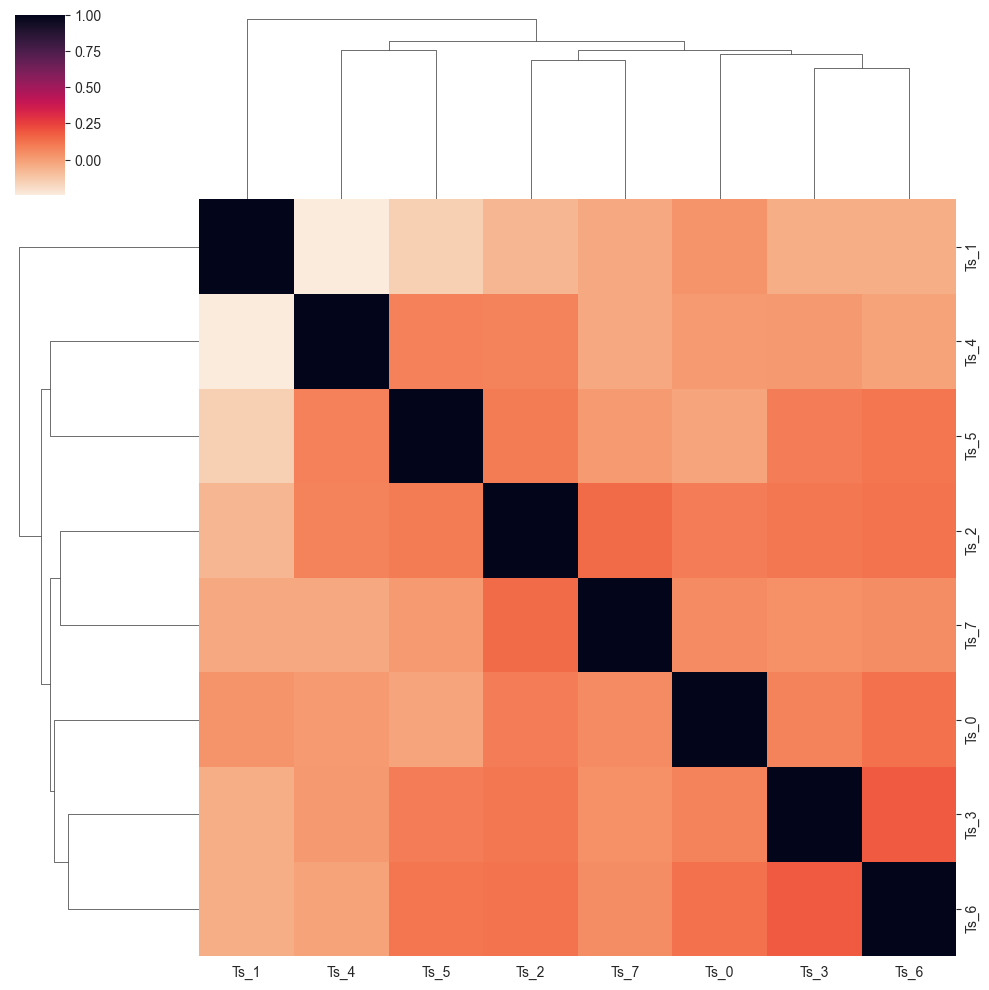

In [342]:
#investigating the correlation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

sns_plot = sns.clustermap(Xt_df.corr(), cmap="rocket_r")
vif_data = pd.DataFrame()
vif_data["Feature"] = Xt_df.columns
vif_data["VIF"] = [variance_inflation_factor(Xt_df.values, i) for i in range(len(Xt_df.columns))]

print(vif_data)

Let's try with randoom forest! 

In [343]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

scaler = StandardScaler()
Xt = scaler.fit_transform(Xt)
print(Xt)
Xtest = scaler.fit_transform(Xtest)
print(Xtest)

print('Number of training samples: ',Xt.shape[0])

rf_classifier = RandomForestClassifier(n_estimators=30,random_state=42, n_jobs=-1)
rf_classifier.fit(Xt,Yt)


[[ 2.07841093 -0.86318233  2.41561299 ... -0.70666653  0.79691086
   2.30444794]
 [-0.59197879 -0.86318233 -0.55836687 ... -0.70666653 -0.56599225
  -0.72139324]
 [-0.59197879 -0.86318233 -0.55836687 ...  1.58536417 -0.56599225
  -0.72139324]
 ...
 [ 1.59320501 -0.86318233 -0.55836687 ... -0.70666653  1.25377579
  -0.72139324]
 [-0.59197879 -0.86318233  1.18228701 ...  0.63151848  1.53100598
   1.33249258]
 [ 1.37407576 -0.86318233 -0.55836687 ... -0.70666653 -0.56599225
  -0.72139324]]
[[ 0.93688132  1.38812663 -0.55537009 ...  1.68847063  1.61948688
  -0.72003766]
 [-0.58968367  0.86051148 -0.55537009 ... -0.00854794 -0.56291402
  -0.72003766]
 [-0.58968367 -0.85827304 -0.55537009 ... -0.7041813  -0.56291402
  -0.72003766]
 ...
 [-0.58968367  1.78918037 -0.55537009 ... -0.7041813   1.22366721
  -0.72003766]
 [-0.58968367 -0.85827304 -0.55537009 ... -0.7041813  -0.56291402
   0.21637537]
 [ 1.38087007  1.43673602  0.57875647 ... -0.7041813  -0.56291402
   1.28759139]]
Number of traini

RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=42)

In [344]:
y_pred = rf_classifier.predict(Xt)
accuracy = accuracy_score(Yt, y_pred)
print(f'Train accuracy: {accuracy}')

Train accuracy: 0.9899482527968482


In [345]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_test = rf_classifier.predict(Xtest)
test_accuracy = accuracy_score(Ytest, y_pred_test)
conf_matrix = confusion_matrix(Ytest,y_pred_test)
print(f'Test accuracy: {test_accuracy}')
print(conf_matrix)

Test accuracy: 0.6579686282580892
[[  740  9304   245    61    36]
 [ 2830 43823  1312   294   133]
 [  361  5993   183    56    12]
 [  126  1731    73    10     8]
 [   41   626    18     6     1]]


In [327]:
import graphviz
from sklearn.tree import export_graphviz

tree = rf_classifier.estimators_[0]

dot_data = export_graphviz(tree, out_file=None,filled=True,rounded=True, special_characters=True) 

graph = graphviz.Source(dot_data)  
graph.render("iris_tree")  # Save the tree as a file
graph.view()


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Let's try QDA

In [308]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

qda = QuadraticDiscriminantAnalysis()

qda.fit(Xt,Yt)
y_qda_predict = qda.predict(Xt)
qda_train_accuracy = accuracy_score(Yt,y_qda_predict)
y_pred_qda_test = qda.predict(Xtest)
qda_test_accuracy = accuracy_score(Ytest,y_pred_qda_test)
print(f'Train accuracy: {qda_train_accuracy}')
print(confusion_matrix(Yt,y_qda_predict))
print(f'Test accuracy: {qda_test_accuracy}')
print(conf_matrix(Ytest,y_pred_qda_test))


Train accuracy: 0.704667401690555
[[   88  4070     0     0     0]
 [  147 19086     0     0     0]
 [   12  2705     0     0     0]
 [    4   837     0     0     0]
 [    2   259     0     0     0]]
Test accuracy: 0.7064530354255476


TypeError: 'numpy.ndarray' object is not callable

Maybe svm with a radial kernel

In [307]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


scaler =MaxAbsScaler()
Xt_scaled = scaler.fit_transform(Xt)
Xtest_scaled = scaler.fit_transform(Xtest)

svm = SVC(kernel='rbf',C=20.0, gamma='scale',degree=5)
svm.fit(Xt,Yt)
Y_svm_pred = svm.predict(Xt)
print(f'Train accuracy:', accuracy_score(Yt,Y_svm_pred))
conf_matrix_svm = confusion_matrix(Yt,Y_svm_pred)
print(conf_matrix_svm)
Y_svm_pred_test = svm.predict(Xtest)
conf_matrix_svm = confusion_matrix(Ytest,Y_svm_pred_test)
print('Test accuracy:', accuracy_score(Ytest,Y_svm_pred_test))
print(conf_matrix_svm)


Train accuracy: 0.7089672914369717
[[   39  4119     0     0     0]
 [    1 19232     0     0     0]
 [    2  2698    17     0     0]
 [    1   837     1     2     0]
 [    0   260     0     0     1]]
Test accuracy: 0.7088049389975011
[[   4 1051    0    0    0]
 [   5 4818    1    0    0]
 [   1  658    0    0    0]
 [   0  196    0    0    0]
 [   0   69    0    0    0]]
